In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [29]:
from IPython.display import Markdown, display

def print_classification_report_md(y_true, y_pred):
    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True)

    # Build Markdown string for the table
    markdown_str = "| Class | Precision | Recall | F1 Score | Support |\n| --- | --- | --- | --- | --- |\n"
    for key, value in report.items():
        if key == 'accuracy':
            # Skip the accuracy since it's not part of the per-class report
            continue
        if isinstance(value, dict):  # Check if the value is a metrics dictionary
            markdown_str += f"| {key} | {value['precision']:.2f} | {value['recall']:.2f} | {value['f1-score']:.2f} | {value['support']} |\n"

    # Print the overall accuracy as well
    overall_accuracy = report.get('accuracy', None)
    if overall_accuracy is not None:
        markdown_str += f"| **Overall** | | | **Accuracy** | {overall_accuracy:.2f} |\n"

    # Display using Markdown
    display(Markdown(markdown_str))

In [30]:
train_set_url_20_balanced = "data/KDDTrain_20%_balanced.csv"
test_set_url_20 = "data/KDDTest_for20%_processed.csv"

df_train = pd.read_csv(train_set_url_20_balanced)
df_test = pd.read_csv(test_set_url_20)

# Split the dataset into features and target
X = df_train.drop('attack_class', axis=1)
y = df_train['attack_class']

X_test = df_test.drop('attack_class', axis=1)
y_test = df_test['attack_class']

In [31]:
# Define k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring function
scoring = make_scorer(f1_score, zero_division=0, average='weighted')

## Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier

# DECISION TREE

# Define the model
decision_tree = DecisionTreeClassifier(random_state=42)

# Decision Tree hyperparameters grid
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 50],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

# Grid Search with Cross-Validation
grid_search_dt = GridSearchCV(estimator=decision_tree, param_grid=param_grid_dt, scoring=scoring, n_jobs=-1, cv=kfold, verbose=3)
grid_search_dt.fit(X, y)

# Best parameters and best score
print("Best parameters found: ", grid_search_dt.best_params_)
print("Best cross-validated f1 score: ", grid_search_dt.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validated f1 score:  0.9983732104833827


| Class | Precision | Recall | F1 Score | Support |
| --- | --- | --- | --- | --- |
| 0 | 0.96 | 0.78 | 0.86 | 7458.0 |
| 1 | 0.69 | 0.92 | 0.79 | 9711.0 |
| 2 | 0.56 | 0.75 | 0.64 | 2421.0 |
| 3 | 0.38 | 0.05 | 0.09 | 2754.0 |
| 4 | 0.05 | 0.01 | 0.01 | 200.0 |
| macro avg | 0.53 | 0.50 | 0.48 | 22544.0 |
| weighted avg | 0.72 | 0.74 | 0.70 | 22544.0 |
| **Overall** | | | **Accuracy** | 0.74 |


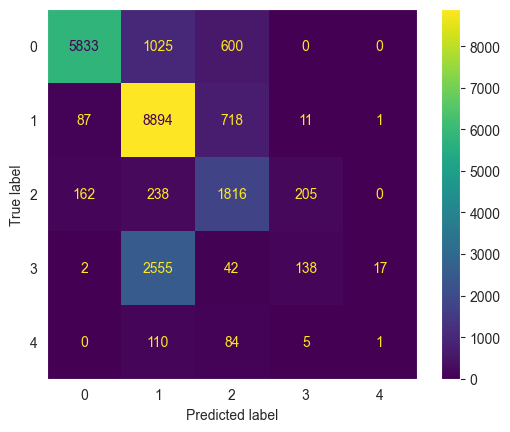

In [34]:
# Get the best estimator
best_estimator_dt = grid_search_dt.best_estimator_

# Prediction
y_pred = best_estimator_dt.predict(X_test)

# Calculate metrics
print_classification_report_md(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.grid(False)
plt.show()

In [35]:
from joblib import dump

# Save the model to a file
dump(best_estimator_dt, 'decision_tree_model.joblib')

['decision_tree_model.joblib']

## KNN

In [6]:
from sklearn.neighbors import KNeighborsClassifier

# Define the model
knn = KNeighborsClassifier()

# Define the parameter grid to search
param_grid_knn = {
    'n_neighbors': [3, 10, 15],  # You can choose more values here based on computational budget
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 is Manhattan distance, 2 is Euclidean distance
}

# Grid Search with Cross-Validation
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, scoring=scoring, n_jobs=-1, cv=kfold, verbose=3)
grid_search_knn.fit(X, y)

# Best parameters and best score
print("Best parameters found: ", grid_search_knn.best_params_)
print("Best cross-validated f1 score: ", grid_search_knn.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best cross-validated f1 score:  0.9997910407945568


| Class | Precision | Recall | F1 Score | Support |
| --- | --- | --- | --- | --- |
| 0 | 0.96 | 0.79 | 0.87 | 7458.0 |
| 1 | 0.68 | 0.97 | 0.80 | 9711.0 |
| 2 | 0.80 | 0.69 | 0.74 | 2421.0 |
| 3 | 0.40 | 0.06 | 0.11 | 2754.0 |
| 4 | 0.73 | 0.12 | 0.21 | 200.0 |
| macro avg | 0.72 | 0.53 | 0.54 | 22544.0 |
| weighted avg | 0.75 | 0.76 | 0.73 | 22544.0 |
| **Overall** | | | **Accuracy** | 0.76 |


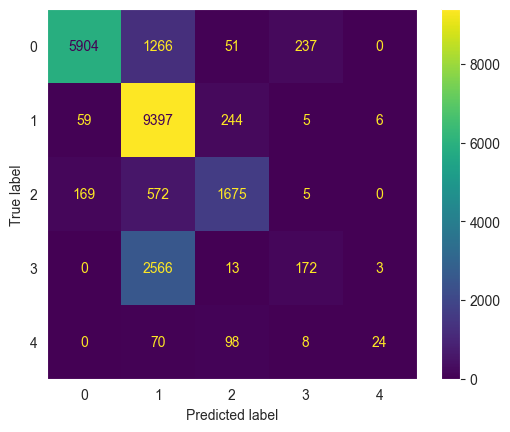

In [22]:
# Get the best estimator
best_estimator_knn = grid_search_knn.best_estimator_

# Prediction
y_pred = best_estimator_knn.predict(X_test)

# Calculate metrics
print_classification_report_md(y_test, y_pred)

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot()
plt.grid(False)
plt.show()

In [23]:
from joblib import dump

# Save the model to a file
dump(best_estimator_knn, 'knn_model.joblib')

['knn_model.joblib']

## Naive Bayes

In [8]:
from sklearn.naive_bayes import GaussianNB

# Define the Naive Bayes classifier
nb_classifier = GaussianNB()

# Define the parameter grid to search
param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Grid Search with Cross-Validation
grid_search_nb = GridSearchCV(estimator=nb_classifier, param_grid=param_grid_nb, scoring=scoring, n_jobs=-1, cv=kfold, verbose=3)
grid_search_nb.fit(X, y)

# Best parameters and best score
print("Best parameters found: ", grid_search_nb.best_params_)
print("Best cross-validated f1 score: ", grid_search_nb.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters found:  {'var_smoothing': 1e-07}
Best cross-validated f1 score:  0.848465775295048


| Class | Precision | Recall | F1 Score | Support |
| --- | --- | --- | --- | --- |
| 0 | 0.89 | 0.49 | 0.63 | 7458.0 |
| 1 | 0.74 | 0.93 | 0.82 | 9711.0 |
| 2 | 0.39 | 0.60 | 0.47 | 2421.0 |
| 3 | 0.56 | 0.42 | 0.48 | 2754.0 |
| 4 | 0.07 | 0.14 | 0.09 | 200.0 |
| macro avg | 0.53 | 0.51 | 0.50 | 22544.0 |
| weighted avg | 0.72 | 0.68 | 0.67 | 22544.0 |
| **Overall** | | | **Accuracy** | 0.68 |


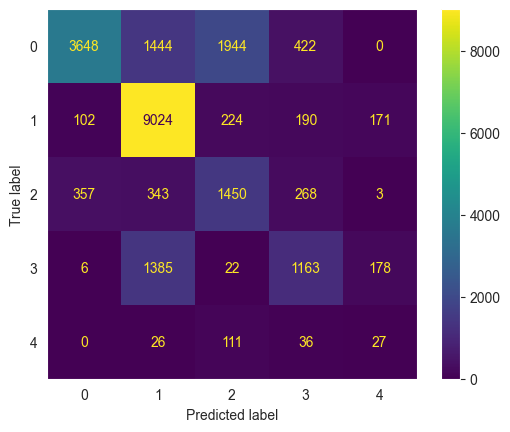

In [21]:
# Get the best estimator
best_estimator_nb = grid_search_nb.best_estimator_

# Prediction
y_pred = best_estimator_nb.predict(X_test)

# Calculate metrics
print_classification_report_md(y_test, y_pred)

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot()
plt.grid(False)
plt.show()

In [36]:
from joblib import dump

# Save the model to a file
dump(best_estimator_nb, 'naive_bayes_model.joblib')

['naive_bayes_model.joblib']

## Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)

# Define the parameter grid to search
param_grid_lr = {
    'C': [0.1, 1.0, 10],  # Regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200]  # Maximum number of iterations taken for the solvers to converge
}

# Grid Search with Cross-Validation
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, scoring=scoring, n_jobs=-1, cv=kfold, verbose=3)
grid_search_lr.fit(X, y)

# Best parameters and best score
print("Best parameters found: ", grid_search_lr.best_params_)
print("Best cross-validated f1 score: ", grid_search_lr.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found:  {'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}
Best cross-validated f1 score:  0.9878349627002981


| Class | Precision | Recall | F1 Score | Support |
| --- | --- | --- | --- | --- |
| 0 | 0.91 | 0.83 | 0.87 | 7458.0 |
| 1 | 0.70 | 0.92 | 0.80 | 9711.0 |
| 2 | 0.84 | 0.74 | 0.79 | 2421.0 |
| 3 | 0.76 | 0.26 | 0.39 | 2754.0 |
| 4 | 0.53 | 0.13 | 0.21 | 200.0 |
| macro avg | 0.75 | 0.57 | 0.61 | 22544.0 |
| weighted avg | 0.79 | 0.78 | 0.76 | 22544.0 |
| **Overall** | | | **Accuracy** | 0.78 |


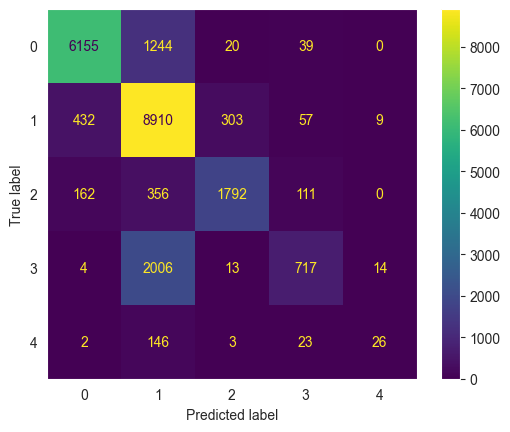

In [24]:
# Get the best estimator
best_estimator_lr = grid_search_lr.best_estimator_

# Prediction
y_pred = best_estimator_lr.predict(X_test)

# Calculate metrics
print_classification_report_md(y_test, y_pred)

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot()
plt.grid(False)
plt.show()

In [25]:
from joblib import dump

# Save the model to a file
dump(best_estimator_lr, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

## SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

params_grid_svc = {
    'C': [0.1, 1],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf'],  # Type of SVM kernel
    'gamma': ['scale', 'auto'],  # Kernel coefficient
}

# Grid Search with Cross-Validation
grid_search_svc = GridSearchCV(estimator=svc, param_grid=params_grid_svc, scoring=scoring, n_jobs=-1, cv=kfold, verbose=3)
grid_search_svc.fit(X, y)

# Best parameters and best score
print("Best parameters found: ", grid_search_svc.best_params_)
print("Best cross-validated f1 score: ", grid_search_svc.best_score_)

In [ ]:
# Get the best estimator
best_estimator_svc = grid_search_svc.best_estimator_

# Prediction
y_pred = best_estimator_svc.predict(X_test)

# Calculate metrics
print_classification_report_md(y_test, y_pred)

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot()
plt.grid(False)
plt.show()

In [ ]:
from joblib import dump

# Save the model to a file
dump(best_estimator_svc, 'svc_model.joblib')

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [10, 100, 200],
    'max_depth': [None, 10, 50],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': [2, 10, 15]
}

# Set up GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=kfold, scoring=scoring, n_jobs=-1, verbose=3)
grid_search_rf.fit(X, y)

# Best parameters and best score
print("Best parameters found: ", grid_search_rf.best_params_)
print("Best cross-validated f1 score: ", grid_search_rf.best_score_)

In [ ]:
# Get the best estimator
best_estimator_rf = grid_search_rf.best_estimator_

# Prediction
y_pred = best_estimator_rf.predict(X_test)

# Calculate metrics
print_classification_report_md(y_test, y_pred)

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot()
plt.grid(False)
plt.show()

In [ ]:
from joblib import dump

# Save the model to a file
dump(best_estimator_rf, 'random_forest_model.joblib')

## Ada Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier()

params_grid_adaboost = {
    'n_estimators': [50, 100, 200],  # Number of weak learners to train iteratively
    'learning_rate': [0.01, 0.1, 1],  # Weight applied to each classifier at each boosting iteration
    'estimator': ['DecisionTreeClassifier', 'GaussianNB']
}

# Set up GridSearchCV for Random Forest
grid_search_adaboost = GridSearchCV(estimator=adaboost, param_grid=params_grid_adaboost, cv=kfold, scoring=scoring, n_jobs=-1, verbose=3)
grid_search_adaboost.fit(X, y)

# Best parameters and best score
print("Best parameters found: ", grid_search_adaboost.best_params_)
print("Best cross-validated f1 score: ", grid_search_adaboost.best_score_)

In [ ]:
# Get the best estimator
best_estimator_adaboost = grid_search_adaboost.best_estimator_

# Prediction
y_pred = best_estimator_adaboost.predict(X_test)

# Calculate metrics
print_classification_report_md(y_test, y_pred)

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot()
plt.grid(False)
plt.show()

In [ ]:
from joblib import dump

# Save the model to a file
dump(best_estimator_adaboost, 'adaboost_model.joblib')